## Лабораторная работа

**Студенты:** Коршунова Анастасия, Деркач Алёна

In [65]:
# pip install imgaug
# pip install torchvision

## **1. Подготовка данных**

В данной лабораторной работе мы будем использовать следующий датасет: https://www.kaggle.com/datasets/ryanbadai/clothes-dataset
В данном датасете `15` папок по `500` фотографий различной одежды:
- Blazer
- Coat
- Dress
- Hoodie
- Jacket
- Jaket_Denim
- Jacket_Sports
- Jeans
- Pants
- Polo
- Shirt
- Shorts
- Skirt
- T-shirt
- Sweater

Разрешение фотографий `720х1280`. Формат `jpg`.

Для задачи классификации изображений хорошо подходят модели из `torchvision.models`, например `EfficientNet-B0`.

В нашей лабораторной мы будем использовать именно её.
- Cовременная и эффективная архитектура, которая обеспечивает высокую точность при относительно небольшом количестве параметров.
- Она легче, чем `ResNet50`, но при этом показывает сравнимую или даже лучшую точность на многих задачах.
- `EfficientNet` оптимизирована для работы на устройствах с ограниченными ресурсами, что делает её хорошим выбором для мобильного использования.

Нам важна как точность, так и скорость, так как потом модель будет использоваться на мобильном телефоне. 

Также модель принимает изображения размером 224x224, поэтому нам нужно будет изменить размер изображений.

Перед обучением модели выполним следующее:
- **Аугментации**
- **Изменение размера изображений**
- **Нормализация** 

In [ ]:
# Библиотеки, которые мы будем использовать
import os
import random
import numpy as np
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import transforms, models, datasets
from torchvision.datasets import ImageFolder
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

import imgaug.augmenters as iaa
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

from torch.nn.functional import one_hot

import pandas as pd
from collections import defaultdict

In [2]:
data_dir = "Clothes_Dataset"

#### **Шаг 1: Аугментация**

Начнём с аугментации. Аугментация добавит разнообразия в классы и поможет можели лучше обучиться. Мы добавим по 200 изображений в папку каждого класса. Так мы сможем наглядно оценить как изменились изображения.

In [8]:
augmentation = iaa.Sequential([
    iaa.Sometimes(0.5, iaa.Fliplr(0.5)),  # Отражение по горизонтали с вероятностью 50%
    iaa.Sometimes(0.3, iaa.Affine(
        rotate=(-30, 30),  # Случайные повороты от -30 до 30 градусов
        scale=(0.8, 1.2)  # Случайное масштабирование
    )),
    iaa.Invert(0.3), # Инверсия цвета
    iaa.ChannelShuffle(0.35), # Перемешивание канало
    iaa.Sometimes(0.3, iaa.Cutout(nb_iterations=2)), # Вырезаем 2 квадратика из изображения
    iaa.Sometimes(0.3, iaa.Dropout2d(p=0.5)), # Смена цвета изображения
    iaa.Sometimes(0.3, iaa.Crop(percent=(0, 0.05))),  # Случайные обрезки
    iaa.Sometimes(0.3, iaa.GaussianBlur(sigma=(0, 1.0))),  # Размытие
    iaa.Sometimes(0.3, iaa.AdditiveGaussianNoise(scale=(0, 0.20 * 255))),  # Гауссов шум
    iaa.Sometimes(0.3, iaa.MultiplyBrightness((0.8, 1.2))),  # Изменение яркости
    iaa.Sometimes(0.3, iaa.MultiplySaturation((0.8, 1.2))),  # Изменение насыщенности
])

def add_augmented_images(class_dir, num_augmented=200):
    # Получаем список всех изображений в папке
    images = [img for img in os.listdir(class_dir) if img.endswith(('.jpg', '.jpeg', '.png'))]
    
    # Выбираем случайные 200 изображений
    selected_images = random.sample(images, min(num_augmented, len(images)))
    
    for img_name in selected_images:
        img_path = os.path.join(class_dir, img_name)
        image = Image.open(img_path)
        
        image_np = np.array(image)
        
        # Применяем аугментацию
        augmented_image_np = augmentation(image=image_np)

        augmented_image = Image.fromarray(augmented_image_np)
        
        # Сохраняем аугментированное изображение
        new_img_name = f"aug_{img_name}"
        new_img_path = os.path.join(class_dir, new_img_name)
        augmented_image.save(new_img_path)

In [9]:
start = time.time()
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        print(f"Добавляем аугментированные изображения для класса: {class_name}")
        add_augmented_images(class_dir)
end = time.time()

print(f'''
===========================================
Аугментация завершена!
Время: {(end - start):.2f} секунд
================================================''')

Добавляем аугментированные изображения для класса: Blazer
Добавляем аугментированные изображения для класса: Coat
Добавляем аугментированные изображения для класса: Dress
Добавляем аугментированные изображения для класса: Hoodie
Добавляем аугментированные изображения для класса: Jacket
Добавляем аугментированные изображения для класса: Jacket_Sports
Добавляем аугментированные изображения для класса: Jaket_Denim
Добавляем аугментированные изображения для класса: Jeans
Добавляем аугментированные изображения для класса: Pants
Добавляем аугментированные изображения для класса: Polo
Добавляем аугментированные изображения для класса: Shirt
Добавляем аугментированные изображения для класса: Shorts
Добавляем аугментированные изображения для класса: Skirt
Добавляем аугментированные изображения для класса: Sweater
Добавляем аугментированные изображения для класса: T-shirt

Аугментация завершена!
Время: 281.12 секунд


#### **Шаг 2: Загрузка данных**

Загрузим наши данные и сразу нормализуем их. Обычно используется нормализация с параметрами:
- Среднее: [0.485, 0.456, 0.406]
- Стандартное отклонение: [0.229, 0.224, 0.225]

Эти значения соответствуют статистике `ImageNet` (крупномасштабная база данных аннотированных изображений), на которой предобучена модель.

In [34]:
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Изменение размера
    transforms.ToTensor(),  # Преобразование в тензор
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Нормализация
])

dataset = ImageFolder(root="Clothes_Dataset", transform=data_transform)

In [35]:
print(f'''
Общее количество изображений: {len(dataset)}
Количество классов: {len(dataset.classes)}
Пример метки и изображения: {dataset[0][1]}, {dataset[0][0].shape}''')


Общее количество изображений: 10500
Количество классов: 15
Пример метки и изображения: 0, torch.Size([3, 224, 224])


#### **Шаг 3: Разделение данных**

Разделим наши данные на 3 выборки: тренировочную (70%), валидационную (15%) и тестовую (15%).

In [36]:
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [37]:
print(f'''
Тренировочная выборка: {len(train_dataset)} изображений
Валидационная выборка: {len(val_dataset)} изображений
Тестовая выборка: {len(test_dataset)} изображений''')


Тренировочная выборка: 7349 изображений
Валидационная выборка: 1575 изображений
Тестовая выборка: 1576 изображений


#### **Проверка**

Теперь посмотрим какие изображения в тренировочной выборке мы получили. Все изображения размером 240х240 пикселей. Также видно несколько аугментированных изображений. В третьем ряду 2 изображения перекрываются квадратами, 2 имеют инверсию цвета, 2 сменили тон.

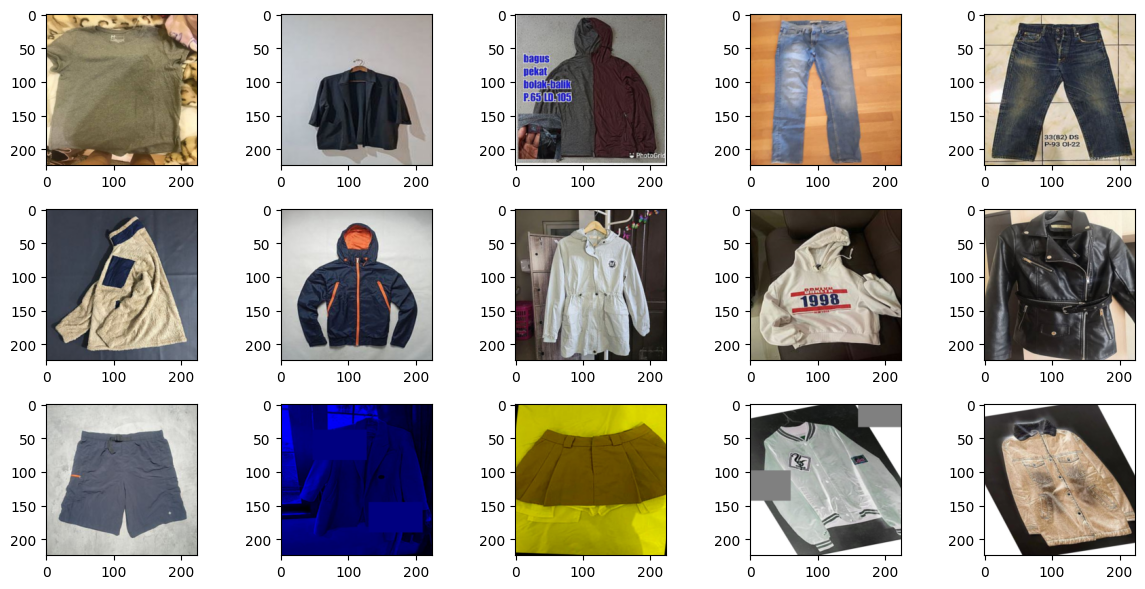

In [37]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

def denormalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    image = image.clone()
    for i in range(3):
        image[i] = image[i] * std[i] + mean[i]
    image = image.numpy().transpose((1, 2, 0))
    image = np.clip(image, 0, 1)
    return image

data_iter = iter(train_loader)
images, labels = next(data_iter)

fig, axes = plt.subplots(3, 5, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    if i < len(images):
        image = denormalize(images[i]) # Денормализуем изображение
        ax.imshow(image)
plt.tight_layout()
plt.show()

## **2. Выбор модели**

Заменим последний полносвязный слой (classifier), чтобы он соответствовал количеству классов в нашем датасете. У нас 15 классов, поэтому выходной слой должен иметь 15 нейронов.

Мы загрузим EfficientNet-B0 с весами, предобученными на ImageNet. Это ускорит обучение и улучшит качество модели.

In [14]:
model = models.efficientnet_b0(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 15) # Замена последнего слоя на 15 классов

На начальном этапе заморозим все слои, кроме последнего, чтобы обучить только его. Это ускорит процесс и предотвратит переобучение.

In [15]:
for param in model.parameters():
    param.requires_grad = False  # Замораживаем все слои
for param in model.classifier.parameters():
    param.requires_grad = True  # Размораживаем последний слой

Также сохраним всю модель (архитектуру + веса) в файл model.pth, чтобы ускорить работу. 

In [11]:
torch.save(model, "model.pth")

## **3. Настройка обучения**

Будем использовать шедулер `ReduceLROnPlateau`. Этот шедулер уменьшает learning rate, если качество модели (например, loss на валидационной выборке) перестает улучшаться. Это помогает модели выйти из локальных минимумов и улучшить качество.

In [39]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, min_lr=1e-6)

Будем использовать раннюю остановку с терпением 5 эпох. Это означает, что если loss на валидации не улучшается в течение 5 эпох, обучение прекратится.

In [40]:
early_stopping_patience = 5
best_val_loss = float('inf')
epochs_without_improvement = 0

Добавим TensorBoard для визуализации.

In [41]:
writer = SummaryWriter('runs/clothes_classification_experiment')

Добавим `Gradient Clipping`. Это техника, которая ограничивает градиенты на каждом шаге обучения. Она предотвращает "взрыв" градиентов, который может произойти, если градиенты становятся слишком большими.

In [42]:
max_grad_norm = 1.0

In [44]:
# Функция для вычисления точности
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    return correct / total

## **4. Обучение модели**

#### **Создание DataLoader**

In [16]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#### **Цикл обучения**

In [ ]:
num_epochs = 20
for epoch in range(num_epochs):
    model.train()  # Переводим модель в режим обучения
    running_loss = 0.0
    running_accuracy = 0.0

    # Прогресс-бар для тренировочной выборки
    train_loop = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", leave=False)
    for inputs, labels in train_loop:
        # Обнуляем градиенты
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        optimizer.step()

        # Считаем метрики
        running_loss += loss.item()
        running_accuracy += calculate_accuracy(outputs, labels)

        train_loop.set_postfix(loss=loss.item())

    # Вычисляем средние loss и accuracy для тренировочной выборки
    train_loss = running_loss / len(train_loader)
    train_accuracy = running_accuracy / len(train_loader)

    # Валидация
    model.eval()  # Переводим модель в режим оценки
    val_loss = 0.0
    val_accuracy = 0.0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_accuracy += calculate_accuracy(outputs, labels)

    val_loss /= len(val_loader)
    val_accuracy /= len(val_loader)

    # Логируем метрики в TensorBoard
    writer.add_scalar('Loss/Train', train_loss, epoch)
    writer.add_scalar('Accuracy/Train', train_accuracy, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('Accuracy/Validation', val_accuracy, epoch)

    # Обновляем шедулер
    scheduler.step(val_loss)

    # Ранняя остановка
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        # Сохраняем лучшую модель
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= early_stopping_patience:
            print(f"Ранняя остановка на эпохе {epoch + 1}")
            break

    # Выводим результаты эпохи
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Закрываем TensorBoard
writer.close()

# Сохраняем финальную модель
torch.save(model.state_dict(), 'final_model.pth')

Epoch 1/20
Train Loss: 1.9249, Train Accuracy: 0.4600
Validation Loss: 1.4779, Validation Accuracy: 0.5814


Epoch 2/20
Train Loss: 1.4114, Train Accuracy: 0.5858
Validation Loss: 1.2892, Validation Accuracy: 0.6221


Epoch 3/20
Train Loss: 1.2616, Train Accuracy: 0.6214
Validation Loss: 1.2040, Validation Accuracy: 0.6274


Epoch 4/20
Train Loss: 1.1698, Train Accuracy: 0.6474
Validation Loss: 1.1737, Validation Accuracy: 0.6293


Epoch 5/20
Train Loss: 1.1103, Train Accuracy: 0.6593
Validation Loss: 1.1265, Validation Accuracy: 0.6521


Epoch 6/20
Train Loss: 1.0679, Train Accuracy: 0.6715
Validation Loss: 1.1155, Validation Accuracy: 0.6364


Epoch 7/20
Train Loss: 1.0414, Train Accuracy: 0.6703
Validation Loss: 1.0988, Validation Accuracy: 0.6568


Epoch 8/20
Train Loss: 1.0084, Train Accuracy: 0.6877
Validation Loss: 1.0829, Validation Accuracy: 0.6540


Epoch 9/20
Train Loss: 0.9817, Train Accuracy: 0.6892
Validation Loss: 1.0704, Validation Accuracy: 0.6574


Epoch 10/20
Train Loss: 0.9649, Train Accuracy: 0.6925
Validation Loss: 1.0648, Validation Accuracy: 0.6580


Epoch 11/20
Train Loss: 0.9469, Train Accuracy: 0.7053
Validation Loss: 1.0441, Validation Accuracy: 0.6605


Epoch 12/20
Train Loss: 0.9330, Train Accuracy: 0.7052
Validation Loss: 1.0441, Validation Accuracy: 0.6621


Epoch 13/20
Train Loss: 0.9160, Train Accuracy: 0.7075
Validation Loss: 1.0443, Validation Accuracy: 0.6630


Epoch 14/20
Train Loss: 0.9114, Train Accuracy: 0.7121
Validation Loss: 1.0446, Validation Accuracy: 0.6605


Epoch 15/20
Train Loss: 0.9076, Train Accuracy: 0.7078
Validation Loss: 1.0427, Validation Accuracy: 0.6624


Epoch 16/20
Train Loss: 0.8904, Train Accuracy: 0.7208
Validation Loss: 1.0372, Validation Accuracy: 0.6696


Epoch 17/20
Train Loss: 0.8969, Train Accuracy: 0.7134
Validation Loss: 1.0360, Validation Accuracy: 0.6680


Epoch 18/20
Train Loss: 0.8623, Train Accuracy: 0.7197
Validation Loss: 1.0193, Validation Accuracy: 0.6668


Epoch 19/20
Train Loss: 0.8598, Train Accuracy: 0.7234
Validation Loss: 1.0402, Validation Accuracy: 0.6665


Epoch 20/20
Train Loss: 0.8661, Train Accuracy: 0.7149
Validation Loss: 1.0367, Validation Accuracy: 0.6656


## **5. Тестирование модели**

Теперь можно протестировать нашу модель на тестовой выборке. Заодно сравним `best_model.pth` и `final_model.pth`.

In [63]:
# Загрузка сохраненных весов
def load_w(model):
    model.eval()  # Переводим модель в режим оценки

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return all_labels, all_preds

In [ ]:
# Метрики
def metrics(all_labels, all_preds, name):
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')

    print(f'''
== {name}_model =================
Test Accuracy: {accuracy:.4f}
Test F1-Score: {f1:.4f}
Test Recall: {recall:.4f}''')

    # with open(f'test_results_{name}.txt', 'w') as f:
    #     f.write(f"Accuracy: {accuracy:.4f}\n")
    #     f.write(f"F1-Score: {f1:.4f}\n")
    #     f.write(f"Recall: {recall:.4f}\n")
    
    pass

In [141]:
# Confusion Matrix
def conf_matrix(all_labels, all_preds, name):

    class_names = ["Blazer", "Coat", "Dress", "Hoodie", "Jacket",
        "Jaket_Denim", "Jacket_Sports", "Jeans", "Pants", "Polo",
        "Shirt", "Shorts", "Skirt", "T-shirt", "Sweater"]
    
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig(f'''confusion_matrix_{name}.png''')
    plt.show()
    
    pass

In [132]:
# Список правильных/неправильных
import pandas as pd
from collections import defaultdict

def count_true(all_preds, all_labels, name):
    # Словарь для хранения статистики
    stats = defaultdict(lambda: {'True': 0, 'False': 0})

    for pred, label in zip(all_preds, all_labels):
        if pred == label:
            stats[label]['True'] += 1
        else:
            stats[label]['False'] += 1

    class_names = ["Blazer", "Coat", "Dress", "Hoodie", "Jacket",
    "Jaket_Denim", "Jacket_Sports", "Jeans", "Pants", "Polo",
    "Shirt", "Shorts", "Skirt", "T-shirt", "Sweater"]

    # Преобразуем словарь в таблицу
    table = []
    for label, counts in stats.items():
        table.append({
            'label': class_names[label],
            f'{name} True': counts['True'],
            f'{name} False': counts['False']
        })

    df = pd.DataFrame(table)
    df = df.sort_values(by='label')
    df.set_index('label', inplace=True)
    df.index.names = [None]

    return df

In [67]:
model.load_state_dict(torch.load('final_model.pth'))
final_all_preds, final_all_labels = load_w(model)

model.load_state_dict(torch.load('best_model.pth'))
best_all_preds, best_all_labels = load_w(model)

In [68]:
metrics(final_all_preds, final_all_labels, 'final')
metrics(best_all_preds, best_all_labels, 'best')


== final_model =================
Test Accuracy: 0.7570
Test F1-Score: 0.7561
Test Recall: 0.7570

== best_model =================
Test Accuracy: 0.7614
Test F1-Score: 0.7593
Test Recall: 0.7614


По метрикам best_model лучше, чем final_model, что и ожидалось. Но 

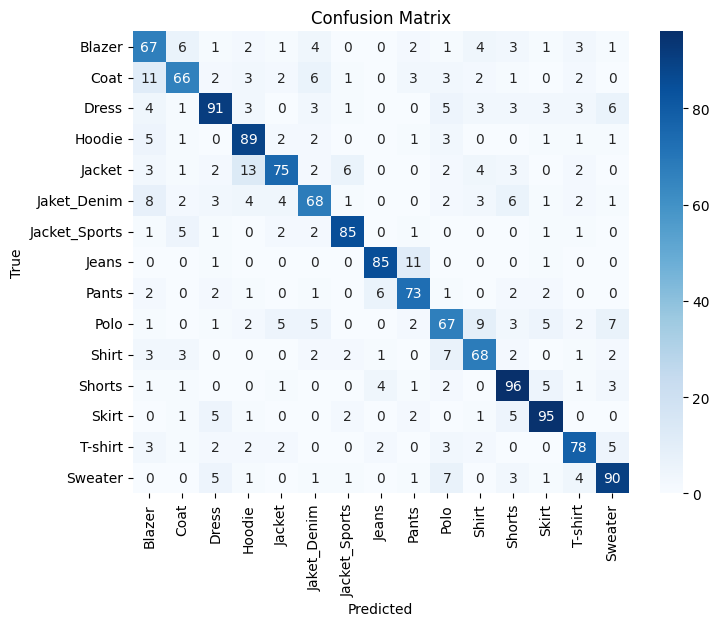

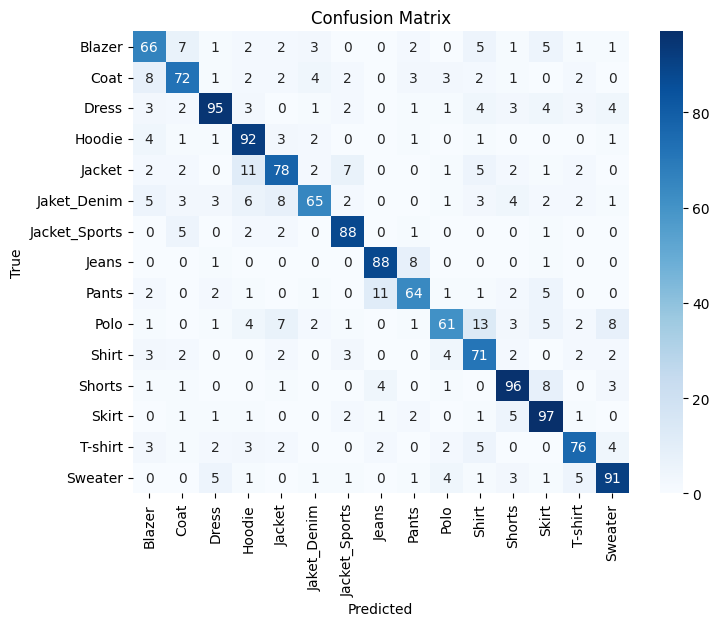

In [142]:
conf_matrix(final_all_preds, final_all_labels, 'final')
conf_matrix(best_all_preds, best_all_labels, 'best')

Теперь просто просуммируем все правильные и неправильные предсказания.

In [149]:
f_df = count_true(final_all_preds, final_all_labels, 'final')
b_df = count_true(best_all_preds, best_all_labels, 'best')

result = pd.concat([f_df, b_df], axis=1)

print('final False:', result['final False'].sum())
print('best False:', result['best False'].sum())

result

final False: 383
best False: 376


,final True,final False,best True,best False
Blazer,67,42,66,32
Coat,66,22,72,25
Dress,91,25,95,18
Hoodie,89,32,92,36
Jacket,75,19,78,29
Jacket_Sports,85,14,88,20
Jaket_Denim,68,28,65,16
Jeans,85,13,88,18
Pants,73,24,64,20
Polo,67,36,61,18


## **6. Улучшение модели**

#### **Аугментация**

Добавим ещё один вид аугментации. `CutMix` — это метод, который вырезает патчи из одного изображения и вставляет их в другое. Это сохраняет целостность исходных изображений и создает более разнообразные тренировочные образцы. Метки также корректируются в соответствии с площадью вырезанного патча.

In [ ]:
def cutmix_data(x, y, alpha=1.0):
    '''__________________________________________________________________________

    torch.randperm(batch_size) создает случайную перестановку индексов от 0 до batch_size - 1.
    Это используется для перемешивания изображений и их меток.
    shuffled_x и shuffled_y - это перемешанные версии исходного батча x и меток y.
    __________________________________________________________________________'''

    batch_size, _, height, width = x.size()
    indices = torch.randperm(batch_size)
    shuffled_x = x[indices]
    shuffled_y = y[indices]

    '''__________________________________________________________________________

    lam - это параметр, который определяет, насколько сильно будет смешано изображение.
    Он выбирается из бета-распределения с параметрами alpha и alpha. Чем больше alpha,
    тем более равномерно будет распределено значение lam.
    __________________________________________________________________________'''

    lam = np.random.beta(alpha, alpha)
    cut_ratio = np.sqrt(1 - lam) # Определяет размер вырезаемой области. 
    cut_width = int(width * cut_ratio)
    cut_height = int(height * cut_ratio)

    # Cлучайные координаты центра вырезаемой области
    cx = np.random.randint(width)
    cy = np.random.randint(height)
    # Левый верхнйи и правый нижний углы
    x1 = int(np.clip(cx - cut_width // 2, 0, width))
    y1 = int(np.clip(cy - cut_height // 2, 0, height))
    x2 = int(np.clip(cx + cut_width // 2, 0, width))
    y2 = int(np.clip(cy + cut_height // 2, 0, height))

    mixed_x = x.clone()
    mixed_x[:, :, y1:y2, x1:x2] = shuffled_x[:, :, y1:y2, x1:x2]
    lam = 1 - ((x2 - x1) * (y2 - y1) / (width * height))
    mixed_y = y * lam + shuffled_y * (1 - lam)

    return mixed_x, mixed_y

#### **Разморозка слоёв**

Разморозим последние несколько слоёв EfficientNet-B0. Это позволит модели адаптироваться к нашим данным, не переобучаясь.

In [52]:
for param in model.features[7].parameters():
    param.requires_grad = True
for param in model.features[8].parameters():
    param.requires_grad = True

Используем меньший learning rate для дообучения.

In [53]:
optimizer = optim.SGD(filter(lambda p: p.requires_grad,
                             model.parameters()),
                             lr=0.0001,
                             momentum=0.9,
                             weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, min_lr=1e-6)

In [ ]:
writer_finetune = SummaryWriter('runs/clothes_classification_finetune')

best_val_loss = float('inf')

Теперь мы можем дообучить модель на 10 эпохах

In [ ]:
for epoch in range(10):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0

    train_loop = tqdm(train_loader, desc=f"Fine-tuning Epoch {epoch + 1}/10", leave=False)
    for inputs, labels in train_loop:
        
        # Преобразуем метки в one-hot encoded формат
        labels_one_hot = torch.nn.functional.one_hot(labels, num_classes=15).float()
        
        # Применяем CutMix
        inputs, labels_mixed = cutmix_data(inputs, labels_one_hot)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        # Преобразуем mixed метки обратно в индексы классов
        labels_indices = labels_mixed.argmax(dim=1)
        
        # Вычисляем loss
        loss = criterion(outputs, labels_indices)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        running_loss += loss.item()
        running_accuracy += accuracy_score(labels_indices.cpu().numpy(), outputs.argmax(dim=1).cpu().numpy())
        train_loop.set_postfix(loss=loss.item())

    train_loss = running_loss / len(train_loader)
    train_accuracy = running_accuracy / len(train_loader)

    # Валидация
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_accuracy += accuracy_score(labels.cpu().numpy(), outputs.argmax(dim=1).cpu().numpy())

    val_loss /= len(val_loader)
    val_accuracy /= len(val_loader)

    # Логирование в TensorBoard
    writer_finetune.add_scalar('Loss/Train (Fine-tuning)', train_loss, epoch)
    writer_finetune.add_scalar('Accuracy/Train (Fine-tuning)', train_accuracy, epoch)
    writer_finetune.add_scalar('Loss/Validation (Fine-tuning)', val_loss, epoch)
    writer_finetune.add_scalar('Accuracy/Validation (Fine-tuning)', val_accuracy, epoch)

    # Обновление шедулера
    scheduler.step(val_loss)

    # Ранняя остановка
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), 'best_model_finetuned.pth')
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= early_stopping_patience:
            print(f"Ранняя остановка на эпохе {epoch + 1}")
            break

    print(f"Fine-tuning Epoch {epoch + 1}/10")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Закрываем writer для улучшенного обучения
writer_finetune.close()

# Сохранение финальной модели
torch.save(model.state_dict(), 'final_model_finetuned.pth')

Fine-tuning Epoch 1/10
Train Loss: 1.8750, Train Accuracy: 0.4428
Validation Loss: 0.8343, Validation Accuracy: 0.7483


Fine-tuning Epoch 2/10
Train Loss: 1.9150, Train Accuracy: 0.4358
Validation Loss: 0.8286, Validation Accuracy: 0.7452


Fine-tuning Epoch 3/10
Train Loss: 1.7683, Train Accuracy: 0.4591
Validation Loss: 0.8578, Validation Accuracy: 0.7430


Fine-tuning Epoch 4/10
Train Loss: 1.8883, Train Accuracy: 0.4389
Validation Loss: 0.8391, Validation Accuracy: 0.7468


Fine-tuning Epoch 5/10
Train Loss: 1.7836, Train Accuracy: 0.4572
Validation Loss: 0.8061, Validation Accuracy: 0.7533


Fine-tuning Epoch 6/10
Train Loss: 1.8816, Train Accuracy: 0.4365
Validation Loss: 0.8417, Validation Accuracy: 0.7515


Fine-tuning Epoch 7/10
Train Loss: 1.8037, Train Accuracy: 0.4552
Validation Loss: 0.8470, Validation Accuracy: 0.7474


Fine-tuning Epoch 8/10
Train Loss: 1.8347, Train Accuracy: 0.4540
Validation Loss: 0.8229, Validation Accuracy: 0.7471


Fine-tuning Epoch 9/10
Train Loss: 1.8354, Train Accuracy: 0.4429
Validation Loss: 0.8197, Validation Accuracy: 0.7518


Ранняя остановка на эпохе 10


In [ ]:
for epoch in range(10):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0

    train_loop = tqdm(train_loader, desc=f"Fine-tuning Epoch {epoch + 1}/10", leave=False)
    for inputs, labels in train_loop:
        
        labels_one_hot = torch.nn.functional.one_hot(labels, num_classes=15).float()
        
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        labels_indices = labels 
        
        # Вычисляем loss
        loss = criterion(outputs, labels_indices)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        running_loss += loss.item()
        running_accuracy += accuracy_score(labels_indices.cpu().numpy(), outputs.argmax(dim=1).cpu().numpy())
        train_loop.set_postfix(loss=loss.item())

    train_loss = running_loss / len(train_loader)
    train_accuracy = running_accuracy / len(train_loader)

    # Валидация
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_accuracy += accuracy_score(labels.cpu().numpy(), outputs.argmax(dim=1).cpu().numpy())

    val_loss /= len(val_loader)
    val_accuracy /= len(val_loader)

    # Логирование в TensorBoard
    writer_finetune.add_scalar('Loss/Train (Fine-tuning)', train_loss, epoch)
    writer_finetune.add_scalar('Accuracy/Train (Fine-tuning)', train_accuracy, epoch)
    writer_finetune.add_scalar('Loss/Validation (Fine-tuning)', val_loss, epoch)
    writer_finetune.add_scalar('Accuracy/Validation (Fine-tuning)', val_accuracy, epoch)

    # Обновление шедулера
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_finetuned.pth')

    print(f"Fine-tuning Epoch {epoch + 1}/10")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

writer_finetune.close()

torch.save(model.state_dict(), 'final_model_finetuned.pth')

Fine-tuning Epoch 1/10
Train Loss: 0.9471, Train Accuracy: 0.6984
Validation Loss: 0.7423, Validation Accuracy: 0.7696


Fine-tuning Epoch 2/10
Train Loss: 0.9435, Train Accuracy: 0.7086
Validation Loss: 0.7444, Validation Accuracy: 0.7673


Fine-tuning Epoch 3/10
Train Loss: 0.9432, Train Accuracy: 0.6993
Validation Loss: 0.7467, Validation Accuracy: 0.7679


Fine-tuning Epoch 4/10:  50%|█████     | 116/230 [02:48<02:40,  1.41s/it, loss=1]    

## **7. Повторное тестирование модели**

In [151]:
# model.load_state_dict(torch.load('final_model_finetuned.pth'))
# final_finetuned_all_preds, final_finetuned_all_labels = load_w(model)

model.load_state_dict(torch.load('best_model_finetuned.pth'))
best_finetuned_all_preds, best_finetuned_all_labels = load_w(model)

In [152]:
# metrics(final_finetuned_all_preds, final_finetuned_all_labels, 'final')
metrics(best_finetuned_all_preds, best_finetuned_all_labels, 'best')


== best_model =================
Test Accuracy: 0.7373
Test F1-Score: 0.7353
Test Recall: 0.7373


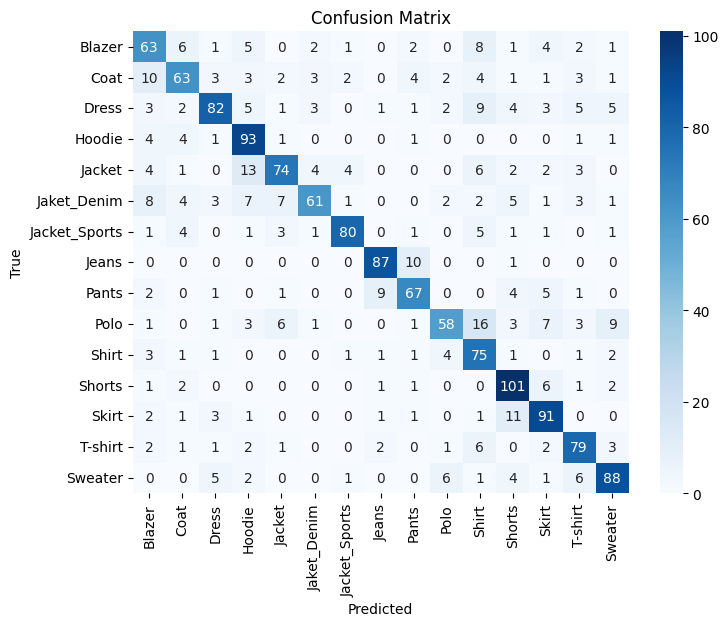

In [154]:
# conf_matrix(final_finetuned_all_preds, final_finetuned_all_labels, 'final')
conf_matrix(best_finetuned_all_preds, best_finetuned_all_labels, 'best')

In [157]:
bf_df = count_true(best_finetuned_all_preds, best_finetuned_all_labels, 'best')
print(bf_df['best False'].sum())
bf_df

414


,best True,best False
Blazer,63,41
Coat,63,26
Dress,82,20
Hoodie,93,42
Jacket,74,22
Jacket_Sports,80,10
Jaket_Denim,61,14
Jeans,87,15
Pants,67,23
Polo,58,17


## **Завершение**

Теперь можно опробовать нашу обученную модель на наших собственных фотографиях. Для этого мы сделаем небольшое интерактивное веб-приложение с помощью `Streamlit`. Приложение записано в файл: `app.py`.

In [ ]:
# python -m streamlit run app.py

А теперь удаляем все аугментированные изображения из нашего датасета. 

In [5]:
data_dir = "Clothes_Dataset"

# Функция для удаления аугментированных изображений
def remove_augmented_images(class_dir):
    files = os.listdir(class_dir)
    
    # Удаляем файлы, начинающиеся с "aug_"
    for file_name in files:
        if file_name.startswith("aug_") and file_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            file_path = os.path.join(class_dir, file_name)
            os.remove(file_path)

# Проходим по всем папкам с классами
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        print(f"Удаляем аугментированные изображения для класса: {class_name}")
        remove_augmented_images(class_dir)

print(f'''
================================================
Удаление аугментированных изображений завершено!
================================================''')

Удаляем аугментированные изображения для класса: Blazer
Удаляем аугментированные изображения для класса: Coat
Удаляем аугментированные изображения для класса: Dress
Удаляем аугментированные изображения для класса: Hoodie
Удаляем аугментированные изображения для класса: Jacket
Удаляем аугментированные изображения для класса: Jacket_Sports
Удаляем аугментированные изображения для класса: Jaket_Denim
Удаляем аугментированные изображения для класса: Jeans
Удаляем аугментированные изображения для класса: Pants
Удаляем аугментированные изображения для класса: Polo
Удаляем аугментированные изображения для класса: Shirt
Удаляем аугментированные изображения для класса: Shorts
Удаляем аугментированные изображения для класса: Skirt
Удаляем аугментированные изображения для класса: Sweater
Удаляем аугментированные изображения для класса: T-shirt

Удаление аугментированных изображений завершено!
